In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from torchvision import transforms, datasets
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class EMA:
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = self.decay * self.shadow[name] + (1.0 - self.decay) * param.data
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

In [3]:
def cosine_beta_schedule(timesteps, s=0.008, device='cuda'):
    steps = torch.arange(timesteps, dtype=torch.float32, device=device) / timesteps
    f_t = torch.cos((steps + s) / (1 + s) * torch.pi / 2) ** 2
    betas = torch.clamp(1 - f_t / f_t.roll(1), min=0.0001, max=0.9999)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
    return betas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod

In [4]:
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02, device='cuda'):
    betas = torch.linspace(beta_start, beta_end, timesteps)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
    return betas.to(device), alphas_cumprod.to(device), sqrt_alphas_cumprod.to(device), sqrt_one_minus_alphas_cumprod.to(device)

In [5]:
num_timesteps = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
betas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod = cosine_beta_schedule(num_timesteps, device=device)

In [6]:
def extract_params(t, device):
    t = t.view(-1).to(device)
    beta_t = betas[t].view(-1, 1, 1, 1).to(device)
    sqrt_alpha_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1).to(device)
    sqrt_one_minus_alpha_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1).to(device)
    return beta_t, sqrt_alpha_t, sqrt_one_minus_alpha_t

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        super().__init__()
        assert in_channels % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = in_channels // num_heads
        self.scale = self.head_dim ** -0.5
        self.to_q = nn.Conv2d(in_channels, in_channels, 1)
        self.to_k = nn.Conv2d(in_channels, in_channels, 1)
        self.to_v = nn.Conv2d(in_channels, in_channels, 1)
        self.to_out = nn.Conv2d(in_channels, in_channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        N = H * W
        q = self.to_q(x).view(B, self.num_heads, self.head_dim, N).permute(0,1,3,2)
        k = self.to_k(x).view(B, self.num_heads, self.head_dim, N).permute(0,1,3,2)
        v = self.to_v(x).view(B, self.num_heads, self.head_dim, N).permute(0,1,3,2)
        # attn = torch.matmul(q, k) * self.scale
        # attn = F.softmax(attn, dim=-1)
        # out = torch.matmul(attn, v)
        out = F.scaled_dot_product_attention(q, k, v)
        out = out.permute(0,1,3,2).reshape(B, C, H, W)
        return x + self.to_out(out)

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=512, norm_groups=8):
        super().__init__()
        self.time_proj = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, out_ch))
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(norm_groups, out_ch)
        self.act1 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(norm_groups, out_ch)
        self.act2 = nn.SiLU()
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.skip(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act1(x)
        x = x + self.time_proj(t_emb)[:, :, None, None]
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act2(x)
        return x + h

class UNet128(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, time_emb_dim=512):
        super().__init__()
        # time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(128, time_emb_dim), nn.SiLU(), nn.Linear(time_emb_dim, time_emb_dim)
        )
        # initial conv to concat later
        self.init = nn.Conv2d(in_ch, 64, 3, padding=1)
        # down blocks: 128x128 -> 64 -> 32 -> 16 -> 8 -> 4
        self.down1 = nn.Conv2d(64, 128, 4, 2, 1); self.rb1 = ResBlock(128, 128, time_emb_dim)
        self.down2 = nn.Conv2d(128, 256, 4, 2, 1); self.rb2 = ResBlock(256, 256, time_emb_dim)
        self.down3 = nn.Conv2d(256, 512, 4, 2, 1); self.rb3 = ResBlock(512, 512, time_emb_dim)
        self.down4 = nn.Conv2d(512, 1024, 4, 2, 1); self.rb4 = ResBlock(1024, 1024, time_emb_dim)
        # bottleneck
        self.mid1 = ResBlock(1024, 1024, time_emb_dim)
        self.mid_attn = SelfAttention(1024, num_heads=8)
        self.mid2 = ResBlock(1024, 1024, time_emb_dim)
        # up blocks: 4 -> 8 -> 16 -> 32 -> 64
        self.up4 = nn.ConvTranspose2d(1024, 512, 4, 2, 1); self.urb4 = ResBlock(1024, 512, time_emb_dim)
        self.attn4 = SelfAttention(512, num_heads=8)
        self.up3 = nn.ConvTranspose2d(512, 256, 4, 2, 1); self.urb3 = ResBlock(512, 256, time_emb_dim)
        self.attn3 = SelfAttention(256, num_heads=8)
        self.up2 = nn.ConvTranspose2d(256, 128, 4, 2, 1); self.urb2 = ResBlock(256, 128, time_emb_dim)
        self.attn2 = SelfAttention(128, num_heads=4)
        self.up1 = nn.ConvTranspose2d(128, 64, 4, 2, 1); self.urb1 = ResBlock(128, 64, time_emb_dim)
        self.attn1 = SelfAttention(64, num_heads=4)
        # final conv to get back to image(128x128)
        self.final = nn.Conv2d(64, out_ch, 3, padding=1)

    def sinusoidal_embedding(self, t, dim=128):
        half = dim // 2
        freq = torch.exp(-torch.log(torch.tensor(10000.0)) * torch.arange(half, device=t.device) / (half - 1))
        emb = t[:, None] * freq[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

    def forward(self, x, t):
        t = t.to(x.device).float()
        temb = self.time_embed(self.sinusoidal_embedding(t))
        
        x0 = self.init(x)

        d1 = self.down1(x0)
        d1 = self.rb1(d1, temb)
        d2 = self.down2(d1)
        d2 = self.rb2(d2, temb)
        d3 = self.down3(d2)
        d3 = self.rb3(d3, temb)
        d4 = self.down4(d3)
        d4 = self.rb4(d4, temb)

        m = self.mid1(d4, temb)
        m = self.mid_attn(m)
        m = self.mid2(m, temb)
        
        u4 = self.up4(m); u4 = torch.cat([u4, d3], dim=1)
        u4 = self.urb4(u4, temb)
        u4 = self.attn4(u4)
        u3 = self.up3(u4)
        u3 = torch.cat([u3, d2], dim=1)
        u3 = self.urb3(u3, temb) 
        u2 = self.up2(u3)
        u2 = torch.cat([u2, d1], dim=1)
        u2 = self.urb2(u2, temb) 
        u1 = self.up1(u2)
        u1 = torch.cat([u1, x0], dim=1)
        u1 = self.urb1(u1, temb)
        return self.final(u1)


In [8]:
def sample(model, img_size, channels, sample_steps, eta, n_samples=4, device='cuda'):
    model.eval()
    with torch.no_grad():
        T = betas.shape[0]
        step_indices = torch.linspace(T-1, 0, steps=sample_steps+1, dtype=torch.long, device=device).round().long()
        timesteps = step_indices[:-1]
        next_timesteps = step_indices[1:]

        x = torch.randn(n_samples, channels, img_size, img_size, device=device)

        for i, (t, t_next) in enumerate(zip(timesteps, next_timesteps)):
            t_tensor = torch.full((n_samples,), t, dtype=torch.long, device=device)
            
            predicted_noise = model(x, t_tensor)

            alpha_bar_t = alphas_cumprod[t]
            alpha_bar_t_next = alphas_cumprod[t_next]
            sqrt_alpha_bar_t = sqrt_alphas_cumprod[t]
            sqrt_alpha_bar_t_next = sqrt_alphas_cumprod[t_next]
            sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alphas_cumprod[t]

            x_0_pred = (x - sqrt_one_minus_alpha_bar_t * predicted_noise) / sqrt_alpha_bar_t
            x_0_pred = torch.clamp(x_0_pred, -1., 1.)

            sigma_t = eta * torch.sqrt((1 - alpha_bar_t_next) / (1 - alpha_bar_t) * (1 - alpha_bar_t / alpha_bar_t_next))
            sigma_t = torch.clamp(sigma_t, 0., 1.)
            noise = torch.randn_like(x) * sigma_t if t_next > 0 else torch.zeros_like(x)

            x = sqrt_alpha_bar_t_next * x_0_pred + torch.sqrt(1 - alpha_bar_t_next - sigma_t**2) * predicted_noise + noise
            x = torch.nan_to_num(x, nan=0.0)

        x = torch.clamp(x, -1., 1.)
        return x


def display_samples(samples, epoch, save_path=None):
    samples = samples.cpu().numpy()
    samples = (samples * 0.5 + 0.5).clip(0, 1)
    samples = samples.transpose(0, 2, 3, 1)
    
    if save_path is None:
        save_path = f'samples_epoch_{epoch}.png'
    
    fig, axes = plt.subplots(1, len(samples), figsize=(len(samples) * 3, 3))
    for i, ax in enumerate(axes if len(samples) > 1 else [axes]):
        ax.imshow(samples[i])
        ax.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# dataset = datasets.ImageFolder(root='C:/Users/ARYAN PALIMKAR/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3', transform=transform)
dataset = datasets.ImageFolder(root='/home/aryan/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

In [10]:
save_dir = 'diffusion_checkpoints_333_3'
sample_dir = 'diffusion_samples_333_3'
os.makedirs(save_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
num_epochs = 50
learning_rate = 5e-5
batch_size = 16
ema_decay = 0.9999
gradient_clip = 1.0
log_interval = 10000
sample_interval = 1000
checkpoint_interval = 10

In [18]:
model = UNet128().to(device)
model = torch.compile(model)
ema = EMA(model, decay=ema_decay)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01, fused=True)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

In [21]:
checkpoint = torch.load("model_final(probably_last).pth", weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
ema = EMA(model)
shadow = torch.load("ema_model_final(probably_last).pth", weights_only=True)
ema.shadow = shadow['model_state_dict']
# ema.apply_shadow()
# torch.save(model, "model_continue.pth")

RuntimeError: Error(s) in loading state_dict for OptimizedModule:
	Missing key(s) in state_dict: "_orig_mod.time_embed.0.weight", "_orig_mod.time_embed.0.bias", "_orig_mod.time_embed.2.weight", "_orig_mod.time_embed.2.bias", "_orig_mod.init.weight", "_orig_mod.init.bias", "_orig_mod.down1.weight", "_orig_mod.down1.bias", "_orig_mod.rb1.time_proj.1.weight", "_orig_mod.rb1.time_proj.1.bias", "_orig_mod.rb1.conv1.weight", "_orig_mod.rb1.conv1.bias", "_orig_mod.rb1.norm1.weight", "_orig_mod.rb1.norm1.bias", "_orig_mod.rb1.conv2.weight", "_orig_mod.rb1.conv2.bias", "_orig_mod.rb1.norm2.weight", "_orig_mod.rb1.norm2.bias", "_orig_mod.down2.weight", "_orig_mod.down2.bias", "_orig_mod.rb2.time_proj.1.weight", "_orig_mod.rb2.time_proj.1.bias", "_orig_mod.rb2.conv1.weight", "_orig_mod.rb2.conv1.bias", "_orig_mod.rb2.norm1.weight", "_orig_mod.rb2.norm1.bias", "_orig_mod.rb2.conv2.weight", "_orig_mod.rb2.conv2.bias", "_orig_mod.rb2.norm2.weight", "_orig_mod.rb2.norm2.bias", "_orig_mod.down3.weight", "_orig_mod.down3.bias", "_orig_mod.rb3.time_proj.1.weight", "_orig_mod.rb3.time_proj.1.bias", "_orig_mod.rb3.conv1.weight", "_orig_mod.rb3.conv1.bias", "_orig_mod.rb3.norm1.weight", "_orig_mod.rb3.norm1.bias", "_orig_mod.rb3.conv2.weight", "_orig_mod.rb3.conv2.bias", "_orig_mod.rb3.norm2.weight", "_orig_mod.rb3.norm2.bias", "_orig_mod.down4.weight", "_orig_mod.down4.bias", "_orig_mod.rb4.time_proj.1.weight", "_orig_mod.rb4.time_proj.1.bias", "_orig_mod.rb4.conv1.weight", "_orig_mod.rb4.conv1.bias", "_orig_mod.rb4.norm1.weight", "_orig_mod.rb4.norm1.bias", "_orig_mod.rb4.conv2.weight", "_orig_mod.rb4.conv2.bias", "_orig_mod.rb4.norm2.weight", "_orig_mod.rb4.norm2.bias", "_orig_mod.mid1.time_proj.1.weight", "_orig_mod.mid1.time_proj.1.bias", "_orig_mod.mid1.conv1.weight", "_orig_mod.mid1.conv1.bias", "_orig_mod.mid1.norm1.weight", "_orig_mod.mid1.norm1.bias", "_orig_mod.mid1.conv2.weight", "_orig_mod.mid1.conv2.bias", "_orig_mod.mid1.norm2.weight", "_orig_mod.mid1.norm2.bias", "_orig_mod.mid_attn.to_q.weight", "_orig_mod.mid_attn.to_q.bias", "_orig_mod.mid_attn.to_k.weight", "_orig_mod.mid_attn.to_k.bias", "_orig_mod.mid_attn.to_v.weight", "_orig_mod.mid_attn.to_v.bias", "_orig_mod.mid_attn.to_out.weight", "_orig_mod.mid_attn.to_out.bias", "_orig_mod.mid2.time_proj.1.weight", "_orig_mod.mid2.time_proj.1.bias", "_orig_mod.mid2.conv1.weight", "_orig_mod.mid2.conv1.bias", "_orig_mod.mid2.norm1.weight", "_orig_mod.mid2.norm1.bias", "_orig_mod.mid2.conv2.weight", "_orig_mod.mid2.conv2.bias", "_orig_mod.mid2.norm2.weight", "_orig_mod.mid2.norm2.bias", "_orig_mod.up4.weight", "_orig_mod.up4.bias", "_orig_mod.urb4.time_proj.1.weight", "_orig_mod.urb4.time_proj.1.bias", "_orig_mod.urb4.conv1.weight", "_orig_mod.urb4.conv1.bias", "_orig_mod.urb4.norm1.weight", "_orig_mod.urb4.norm1.bias", "_orig_mod.urb4.conv2.weight", "_orig_mod.urb4.conv2.bias", "_orig_mod.urb4.norm2.weight", "_orig_mod.urb4.norm2.bias", "_orig_mod.urb4.skip.weight", "_orig_mod.urb4.skip.bias", "_orig_mod.attn4.to_q.weight", "_orig_mod.attn4.to_q.bias", "_orig_mod.attn4.to_k.weight", "_orig_mod.attn4.to_k.bias", "_orig_mod.attn4.to_v.weight", "_orig_mod.attn4.to_v.bias", "_orig_mod.attn4.to_out.weight", "_orig_mod.attn4.to_out.bias", "_orig_mod.up3.weight", "_orig_mod.up3.bias", "_orig_mod.urb3.time_proj.1.weight", "_orig_mod.urb3.time_proj.1.bias", "_orig_mod.urb3.conv1.weight", "_orig_mod.urb3.conv1.bias", "_orig_mod.urb3.norm1.weight", "_orig_mod.urb3.norm1.bias", "_orig_mod.urb3.conv2.weight", "_orig_mod.urb3.conv2.bias", "_orig_mod.urb3.norm2.weight", "_orig_mod.urb3.norm2.bias", "_orig_mod.urb3.skip.weight", "_orig_mod.urb3.skip.bias", "_orig_mod.attn3.to_q.weight", "_orig_mod.attn3.to_q.bias", "_orig_mod.attn3.to_k.weight", "_orig_mod.attn3.to_k.bias", "_orig_mod.attn3.to_v.weight", "_orig_mod.attn3.to_v.bias", "_orig_mod.attn3.to_out.weight", "_orig_mod.attn3.to_out.bias", "_orig_mod.up2.weight", "_orig_mod.up2.bias", "_orig_mod.urb2.time_proj.1.weight", "_orig_mod.urb2.time_proj.1.bias", "_orig_mod.urb2.conv1.weight", "_orig_mod.urb2.conv1.bias", "_orig_mod.urb2.norm1.weight", "_orig_mod.urb2.norm1.bias", "_orig_mod.urb2.conv2.weight", "_orig_mod.urb2.conv2.bias", "_orig_mod.urb2.norm2.weight", "_orig_mod.urb2.norm2.bias", "_orig_mod.urb2.skip.weight", "_orig_mod.urb2.skip.bias", "_orig_mod.attn2.to_q.weight", "_orig_mod.attn2.to_q.bias", "_orig_mod.attn2.to_k.weight", "_orig_mod.attn2.to_k.bias", "_orig_mod.attn2.to_v.weight", "_orig_mod.attn2.to_v.bias", "_orig_mod.attn2.to_out.weight", "_orig_mod.attn2.to_out.bias", "_orig_mod.up1.weight", "_orig_mod.up1.bias", "_orig_mod.urb1.time_proj.1.weight", "_orig_mod.urb1.time_proj.1.bias", "_orig_mod.urb1.conv1.weight", "_orig_mod.urb1.conv1.bias", "_orig_mod.urb1.norm1.weight", "_orig_mod.urb1.norm1.bias", "_orig_mod.urb1.conv2.weight", "_orig_mod.urb1.conv2.bias", "_orig_mod.urb1.norm2.weight", "_orig_mod.urb1.norm2.bias", "_orig_mod.urb1.skip.weight", "_orig_mod.urb1.skip.bias", "_orig_mod.attn1.to_q.weight", "_orig_mod.attn1.to_q.bias", "_orig_mod.attn1.to_k.weight", "_orig_mod.attn1.to_k.bias", "_orig_mod.attn1.to_v.weight", "_orig_mod.attn1.to_v.bias", "_orig_mod.attn1.to_out.weight", "_orig_mod.attn1.to_out.bias", "_orig_mod.final.weight", "_orig_mod.final.bias". 
	Unexpected key(s) in state_dict: "time_embed.0.weight", "time_embed.0.bias", "time_embed.2.weight", "time_embed.2.bias", "init.weight", "init.bias", "down1.weight", "down1.bias", "rb1.time_proj.1.weight", "rb1.time_proj.1.bias", "rb1.conv1.weight", "rb1.conv1.bias", "rb1.norm1.weight", "rb1.norm1.bias", "rb1.conv2.weight", "rb1.conv2.bias", "rb1.norm2.weight", "rb1.norm2.bias", "down2.weight", "down2.bias", "rb2.time_proj.1.weight", "rb2.time_proj.1.bias", "rb2.conv1.weight", "rb2.conv1.bias", "rb2.norm1.weight", "rb2.norm1.bias", "rb2.conv2.weight", "rb2.conv2.bias", "rb2.norm2.weight", "rb2.norm2.bias", "down3.weight", "down3.bias", "rb3.time_proj.1.weight", "rb3.time_proj.1.bias", "rb3.conv1.weight", "rb3.conv1.bias", "rb3.norm1.weight", "rb3.norm1.bias", "rb3.conv2.weight", "rb3.conv2.bias", "rb3.norm2.weight", "rb3.norm2.bias", "down4.weight", "down4.bias", "rb4.time_proj.1.weight", "rb4.time_proj.1.bias", "rb4.conv1.weight", "rb4.conv1.bias", "rb4.norm1.weight", "rb4.norm1.bias", "rb4.conv2.weight", "rb4.conv2.bias", "rb4.norm2.weight", "rb4.norm2.bias", "mid1.time_proj.1.weight", "mid1.time_proj.1.bias", "mid1.conv1.weight", "mid1.conv1.bias", "mid1.norm1.weight", "mid1.norm1.bias", "mid1.conv2.weight", "mid1.conv2.bias", "mid1.norm2.weight", "mid1.norm2.bias", "mid_attn.to_q.weight", "mid_attn.to_q.bias", "mid_attn.to_k.weight", "mid_attn.to_k.bias", "mid_attn.to_v.weight", "mid_attn.to_v.bias", "mid_attn.to_out.weight", "mid_attn.to_out.bias", "mid2.time_proj.1.weight", "mid2.time_proj.1.bias", "mid2.conv1.weight", "mid2.conv1.bias", "mid2.norm1.weight", "mid2.norm1.bias", "mid2.conv2.weight", "mid2.conv2.bias", "mid2.norm2.weight", "mid2.norm2.bias", "up4.weight", "up4.bias", "urb4.time_proj.1.weight", "urb4.time_proj.1.bias", "urb4.conv1.weight", "urb4.conv1.bias", "urb4.norm1.weight", "urb4.norm1.bias", "urb4.conv2.weight", "urb4.conv2.bias", "urb4.norm2.weight", "urb4.norm2.bias", "urb4.skip.weight", "urb4.skip.bias", "attn4.to_q.weight", "attn4.to_q.bias", "attn4.to_k.weight", "attn4.to_k.bias", "attn4.to_v.weight", "attn4.to_v.bias", "attn4.to_out.weight", "attn4.to_out.bias", "up3.weight", "up3.bias", "urb3.time_proj.1.weight", "urb3.time_proj.1.bias", "urb3.conv1.weight", "urb3.conv1.bias", "urb3.norm1.weight", "urb3.norm1.bias", "urb3.conv2.weight", "urb3.conv2.bias", "urb3.norm2.weight", "urb3.norm2.bias", "urb3.skip.weight", "urb3.skip.bias", "attn3.to_q.weight", "attn3.to_q.bias", "attn3.to_k.weight", "attn3.to_k.bias", "attn3.to_v.weight", "attn3.to_v.bias", "attn3.to_out.weight", "attn3.to_out.bias", "up2.weight", "up2.bias", "urb2.time_proj.1.weight", "urb2.time_proj.1.bias", "urb2.conv1.weight", "urb2.conv1.bias", "urb2.norm1.weight", "urb2.norm1.bias", "urb2.conv2.weight", "urb2.conv2.bias", "urb2.norm2.weight", "urb2.norm2.bias", "urb2.skip.weight", "urb2.skip.bias", "attn2.to_q.weight", "attn2.to_q.bias", "attn2.to_k.weight", "attn2.to_k.bias", "attn2.to_v.weight", "attn2.to_v.bias", "attn2.to_out.weight", "attn2.to_out.bias", "up1.weight", "up1.bias", "urb1.time_proj.1.weight", "urb1.time_proj.1.bias", "urb1.conv1.weight", "urb1.conv1.bias", "urb1.norm1.weight", "urb1.norm1.bias", "urb1.conv2.weight", "urb1.conv2.bias", "urb1.norm2.weight", "urb1.norm2.bias", "urb1.skip.weight", "urb1.skip.bias", "attn1.to_q.weight", "attn1.to_q.bias", "attn1.to_k.weight", "attn1.to_k.bias", "attn1.to_v.weight", "attn1.to_v.bias", "attn1.to_out.weight", "attn1.to_out.bias", "final.weight", "final.bias". 

In [14]:
start_time = time.time()
global_step = 0
loss_history = []
epoch_loss_history = []

In [15]:
import torchvision.models as models
import torchvision.transforms

class VGGPerceptualLoss(nn.Module):
    def __init__(self, layer='relu2_2'):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features.eval().to(device)
        self.vgg_layers = vgg[:9]
        for param in self.vgg_layers.parameters():
            param.requires_grad = False
        self.transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    def forward(self, x, y):
        # Scale [-1,1] to [0,1]
        x = (x + 1) / 2
        y = (y + 1) / 2

        x = self.transform(x)
        y = self.transform(y)
        return F.mse_loss(self.vgg_layers(x), self.vgg_layers(y))

In [16]:
import torchvision.models as models
import torchvision.transforms

class VGGPerceptualLoss(nn.Module):
    def __init__(self, device, layer='relu2_2'):  # relu4_4 is around 36th layer in VGG19
        super().__init__()
        vgg = models.vgg19(pretrained=True).features.eval().to(device)
        self.vgg_layers = vgg[:16]
        for param in self.vgg_layers.parameters():
            param.requires_grad = False
        self.transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    
    def forward(self, x, y):
        # Scale [-1,1] to [0,1]
        x = (x + 1) / 2
        y = (y + 1) / 2

        x = self.transform(x)
        y = self.transform(y)
        return F.mse_loss(self.vgg_layers(x), self.vgg_layers(y))

In [17]:
perceptual_loss_fn = VGGPerceptualLoss().to(device)
perceptual_loss_weight = 0.01

/home/aryan/torchwsl/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aryan/torchwsl/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/aryan/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|████████████████████████████████████████████████████████████████████████████████| 528M/528M [06:04<00:00, 1.52MB/s]


Epoch 1/50:   0%|                                                                              | 0/3973 [00:00<?, ?it/s]/home/aryan/torchwsl/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0521 18:18:24.089000 872 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode
Epoch 1/50:  25%|█████████▌                            | 999/3973 [04:29<11:22,  4.35it/s, avg_loss=0.1458, loss=0.0842]


Generating samples at step 1000...


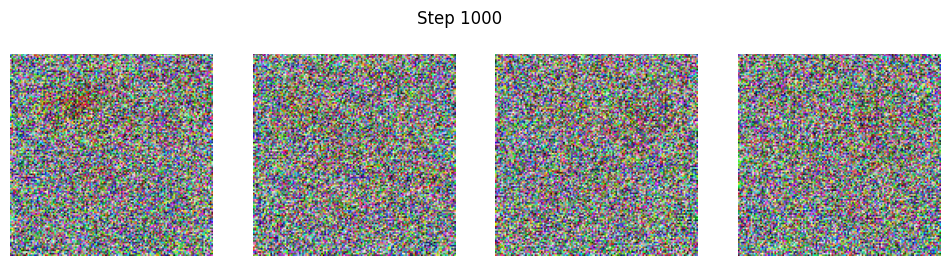

Epoch 1/50:  50%|██████████████████▌                  | 1999/3973 [08:34<07:26,  4.42it/s, avg_loss=0.1097, loss=0.0566]


Generating samples at step 2000...


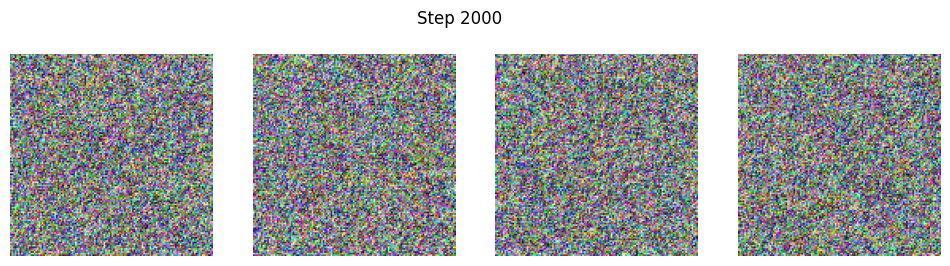

Epoch 1/50:  75%|███████████████████████████▉         | 2999/3973 [12:25<03:47,  4.29it/s, avg_loss=0.0941, loss=0.0755]


Generating samples at step 3000...


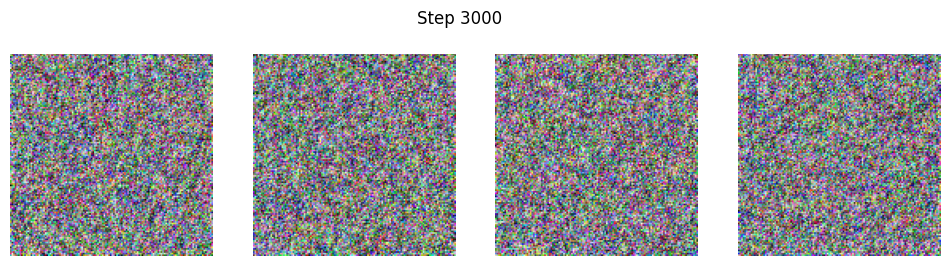

Epoch 1/50:  82%|██████████████████████████████▎      | 3261/3973 [13:29<02:56,  4.03it/s, avg_loss=0.0914, loss=0.0782]

Training interrupted by user


In [20]:
try:
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for batch_idx, (images, _) in enumerate(pbar):
                images = images.to(device)
                batch_size = images.shape[0]
                timesteps = torch.randint(0, num_timesteps, (batch_size,), device=device)
                beta_t, sqrt_alpha_t, sqrt_one_minus_alpha_t = extract_params(timesteps, device)
                noise = torch.randn_like(images)
                noisy_images = sqrt_alpha_t * images + sqrt_one_minus_alpha_t * noise

                with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                    noise_pred = model(noisy_images, timesteps)
                    mse_loss = nn.MSELoss()(noise_pred, noise)

                
                    x0_pred = (noisy_images - sqrt_one_minus_alpha_t * noise_pred) / sqrt_alpha_t
                    x0_target = (noisy_images - sqrt_one_minus_alpha_t * noise) / sqrt_alpha_t
    
                    percep_mask = (timesteps <= 500)
                    if percep_mask.any():
                        x0_pred_vgg = x0_pred[percep_mask]
                        x0_target_vgg = x0_target[percep_mask]
                        perceptual = perceptual_loss_fn(x0_pred_vgg, x0_target_vgg)
                    else:
                        perceptual = torch.tensor(0.0, device=device)
                
                    loss = mse_loss + perceptual_loss_weight * perceptual

                optimizer.zero_grad()
                loss.backward()

                nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                optimizer.step()
                
                ema.update()

                epoch_loss += loss.item()
                pbar.set_postfix(loss=f"{loss.item():.4f}", avg_loss=f"{epoch_loss/(batch_idx+1):.4f}")
                
                global_step += 1

                if global_step % log_interval == 0:
                    current_loss = loss.item()
                    loss_history.append(current_loss)
                    print(f"Step {global_step}, Loss: {current_loss:.6f}")
                
                if global_step % sample_interval == 0:
                    print(f"\nGenerating samples at step {global_step}...")
                    
                    model.eval()

                    ema.apply_shadow()

                    with torch.no_grad():
                        samples = sample(model, n_samples=4, device=device, img_size=128, channels=3, sample_steps=100, eta=0.3)

                    sample_path = f"{sample_dir}/samples_step_{global_step}.png"
                    display_samples(samples, epoch, save_path=sample_path)

                    plt.figure(figsize=(12, 3))
                    samples_np = samples.cpu().numpy()
                    samples_np = (samples_np * 0.5 + 0.5).clip(0, 1)
                    samples_np = samples_np.transpose(0, 2, 3, 1)
                    
                    for i in range(len(samples_np)):
                        plt.subplot(1, len(samples_np), i+1)
                        plt.imshow(samples_np[i])
                        plt.axis('off')
                    plt.suptitle(f'Step {global_step}')
                    display(plt.gcf())
                    plt.close()
                    
                    ema.restore()
                    model.train()

        avg_epoch_loss = epoch_loss / len(dataloader)
        epoch_loss_history.append(avg_epoch_loss)
        
        print(f"\nEpoch {epoch+1}/{num_epochs} completed. Average loss: {avg_epoch_loss:.6f}")
        
        if (epoch + 1) % checkpoint_interval == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_epoch_loss,
                'global_step': global_step
            }, f"{save_dir}/model_epoch_{epoch+1}.pt")
            
            ema.apply_shadow()
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'loss': avg_epoch_loss,
                'global_step': global_step
            }, f"{save_dir}/ema_model_epoch_{epoch+1}.pt")
            ema.restore()
            
            print(f"Checkpoint saved at epoch {epoch+1}")

        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Training Loss (Steps)')
        plt.xlabel('Steps (x100)')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(epoch_loss_history, 'r-')
        plt.title('Average Epoch Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.tight_layout()
        display(plt.gcf())
        plt.close()
        

        scheduler.step()
        
except KeyboardInterrupt:
    print("Training interrupted by user")

In [36]:
torch.save(model, 'model_final_64x64.pth')

In [ ]:
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': avg_epoch_loss,
    'global_step': global_step
}, f"{save_dir}/model_final(do more perc).pth")

ema.apply_shadow()
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'loss': avg_epoch_loss,
    'global_step': global_step
}, f"{save_dir}/ema_model_final(do more perc).pth")

In [25]:
checkpoint = torch.load("model_epoch_90.pt", weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
ema = EMA(model)
shadow = torch.load("ema_model_epoch_90.pt", weights_only=True)
ema.shadow = shadow['model_state_dict']

In [20]:
ema.apply_shadow()

In [38]:
ema.apply_shadow()
samples = sample(model, n_samples=8, device=device, img_size=128, channels=3, sample_steps=150, eta=0.3)
display_samples(samples, epoch=0, save_path=f'samples_epoch_0.png')
ema.restore()